# Implementando um classificador baseado em distância com um circuito de interferência quântica
##### [Maria Schuld, Mark Fingerhuth, Francesco Petruccione](https://arxiv.org/abs/1703.10793)

O classificador quântico aqui disposto utiliza a interferência quântica para medir a distância de um vetor de entrada para cada um dos vetores de treinamento e assim classificá-lo. Como prova de conceito, é montado um circuito quântico para classificar instâncias do conjuto de dados [Iris](http://archive.ics.uci.edu/ml/datasets/Iris).

## Circuito

![title](circuit.jpg)

## Implementação

In [18]:
# Install Libs
import sys
!{sys.executable} -m pip install --user numpy
!{sys.executable} -m pip install --user matplotlib
!{sys.executable} -m pip install --user qiskit
!{sys.executable} -m pip install --user scikit-learn

In [21]:
# Import Libs
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import *
import wavefunction as wf
import iris
import math

In [22]:
# Auxiliary function definitions
def calculate_theta(sample):        
    if sample[0] < 0 and sample[1] < 0:
        value = sample[1]
        theta = math.acos(value)*2+math.pi
    elif sample[1] < 0:
        value = sample[1]
        theta = math.asin(value)*2
    else:
        value = sample[0]
        theta = math.acos(value)*2
    
    return theta

In [54]:
# Preprocessing
classes = [0,1]
features = [0,1]
input_vector_index = 28

X, y = iris.load_dataset(classes=classes, features=features)
X = iris.preprocess(X)

input_vector_theta = calculate_theta(X[input_vector_index])

In [55]:
# Create Circuit
q = QuantumRegister(4, 'q')
c = ClassicalRegister(2, 'c')
qc = QuantumCircuit(q, c)

In [56]:
# Subcircuit A
qc.h(q[[0,1]])

qc.barrier()

In [57]:
# Subcircuit B
qc.cx(q[0], q[2])
qc.ry(-1 * (input_vector_theta / 2.0), q[2])
qc.cx(q[0], q[2])
qc.x(q[0])
qc.ry((input_vector_theta / 2.0), q[2])

qc.barrier()

In [58]:
# Subcircuit C
qc.ccx(q[0], q[1], q[2])
qc.x(q[1])

qc.barrier()

In [59]:
# Subcircuit D
qc.ccx(q[0], q[1], q[2])
qc.cx(q[1], q[2])
qc.ry(0.331, q[2])
qc.cx(q[1], q[2])
qc.ry(-0.331, q[2])
qc.ccx(q[0], q[1], q[2])
qc.cx(q[1], q[2])
qc.ry(-0.331, q[2])
qc.cx(q[1], q[2])
qc.ry(0.331, q[2])

qc.barrier()

In [60]:
# Subcircuit E
qc.cx(q[1], q[3])

qc.barrier()

In [61]:
# Subcircuit F
qc.h(q[0])
wf.Wavefunction(qc)

-0.19714  |0000>   -0.19714  |1000>   0.64705  |0010>   -0.06006  |1010>   0.08173  |0101>   -0.47601  |1101>   0.51082  |0111>   0.07616  |1111>   


In [62]:
# Measure
qc.measure(q[0],c[0])
qc.barrier()
qc.measure(q[3],c[1])

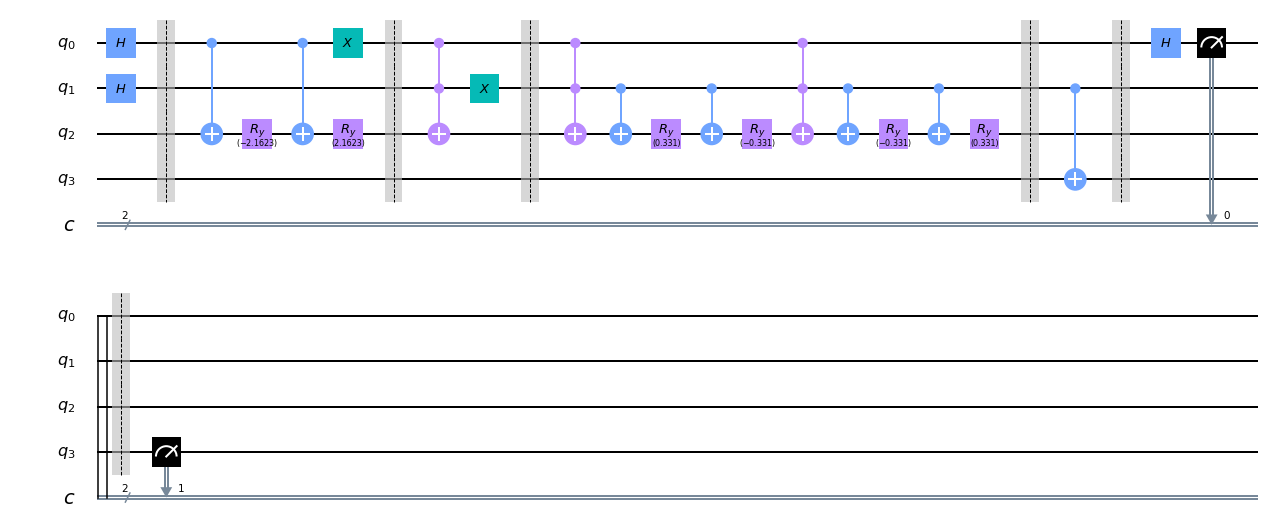

In [63]:
# Print circuit
qc.draw(output = 'mpl')

In [64]:
wf.Measurement(qc, shots = 1024)

262 |01>  479 |00>  39 |10>  244 |11>  


In [65]:
# Simulate
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts(qc)

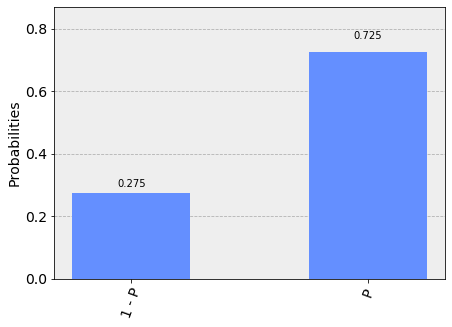

In [66]:
# Postselection probability
pacc = (counts['00'] + counts['10']) / sum(counts.values())
visualization.plot_histogram({ 'P': pacc, '1 - P': (1 - pacc) })

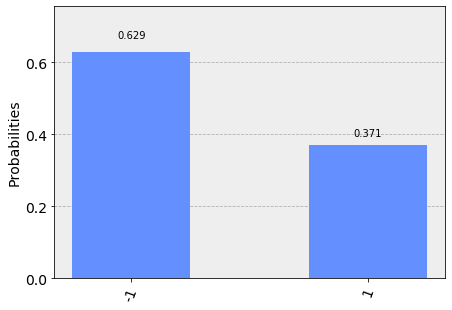

In [67]:
# Classification probability
visualization.plot_histogram({ '-1': counts['00'], '1': counts['10'] })